<a href="https://colab.research.google.com/github/The-cheater/Deep_Learning_Models/blob/main/final_correct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
import os

# Unzip GAF Images
with zipfile.ZipFile('/content/drive/MyDrive/dataset/GAF_Images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/GAF_Images')

# Unzip MTF Images
with zipfile.ZipFile('/content/drive/MyDrive/dataset/MTF_Images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/MTF_Images')

# Check extracted folders
print("GAF Images:", os.listdir('/content/GAF_Images')[:5])
print("MTF Images:", os.listdir('/content/MTF_Images')[:5])


GAF Images: ['GAF_Images']
MTF Images: ['MTF_Images']


In [4]:
# ==========================
# 1️⃣ Imports & Config
# ==========================
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Label mapping
label_map = {'EL': 0, 'PD': 1, 'S': 2}

# ==========================
# 2️⃣ Data Loader Functions
# ==========================
def parse_pair(gaf_path, mtf_path, label):
    # Load GAF
    gaf_img = tf.io.read_file(gaf_path)
    gaf_img = tf.image.decode_png(gaf_img, channels=3)
    gaf_img = tf.image.resize(gaf_img, [224, 224])
    gaf_img = tf.cast(gaf_img, tf.float32) / 255.0

    # Load MTF
    mtf_img = tf.io.read_file(mtf_path)
    mtf_img = tf.image.decode_png(mtf_img, channels=3)
    mtf_img = tf.image.resize(mtf_img, [224, 224])
    mtf_img = tf.cast(mtf_img, tf.float32) / 255.0

    return (gaf_img, mtf_img), label

def create_file_paths_and_labels(gaf_root, mtf_root):
    gaf_paths, mtf_paths, labels = [], [], []

    for root, _, files in os.walk(gaf_root):
        for file in files:
            if file.lower().endswith('_gaf.png'):
                gaf_path = os.path.join(root, file)
                mtf_path = gaf_path.replace('GAF_Images', 'MTF_Images').replace('_gaf.png', '_mtf.png')
                if not os.path.exists(mtf_path):
                    continue  # skip if no corresponding MTF file

                # Determine label
                parts = gaf_path.split(os.sep)
                for cn in label_map.keys():
                    if cn in parts:
                        label = label_map[cn]
                        break
                else:
                    continue

                gaf_paths.append(gaf_path)
                mtf_paths.append(mtf_path)
                labels.append(label)

    return gaf_paths, mtf_paths, labels

# ==========================
# 3️⃣ Dataset Pipeline
# ==========================
gaf_root = '/content/GAF_Images/GAF_Images'
mtf_root = '/content/MTF_Images/MTF_Images'

gaf_paths, mtf_paths, labels = create_file_paths_and_labels(gaf_root, mtf_root)
print(f"✅ Found {len(gaf_paths)} samples.")

batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices((gaf_paths, mtf_paths, labels))
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.map(lambda gaf, mtf, lbl: parse_pair(gaf, mtf, lbl), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

✅ Found 8034 samples.


In [5]:
# ==========================
# 4️⃣ Model: Your MMCNN (Unchanged)
# ==========================
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    return x
# Inputs
input_gaf = Input(shape=(224, 224, 3), name='gaf_input')
input_mtf = Input(shape=(224, 224, 3), name='mtf_input')
# GAF stream (4 blocks)
x1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_gaf)
x1 = conv_block(x1, 128)
x1 = conv_block(x1, 256)
x1 = conv_block(x1, 512)
# MTF stream (4 blocks)
x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_mtf)
x2 = conv_block(x2, 128)
x2 = conv_block(x2, 256)
x2 = conv_block(x2, 512)
# Merge
merged = layers.Concatenate(axis=-1)([x1, x2])
# Additional CNN blocks (matching diagram)
x = layers.Conv2D(512, 3, padding='same', activation='relu')(merged)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# 🟩 GlobalAveragePooling2D
x = layers.Flatten()(x)

# 🟩 Smaller dense layers
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=[input_gaf, input_mtf], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gaf_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mtf_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ gaf_input[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │      1,792 │ mtf_input[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     73,856 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 224, 224,  │     73,856 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │    295,168 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │  1,180,160 │ max_pooling2d_1[

 Total params: 129,750,275 (494.96 MB)

 Trainable params: 129,744,643 (494.94 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [6]:
history = model.fit(dataset, epochs=30)

Epoch 1/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 303s 531ms/step - accuracy: 0.4502 - loss: 33.2491
Epoch 2/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 278s 501ms/step - accuracy: 0.4920 - loss: 1.7409
Epoch 3/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 262s 500ms/step - accuracy: 0.5073 - loss: 1.2287
Epoch 4/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 251s 500ms/step - accuracy: 0.5381 - loss: 1.1340
Epoch 5/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 262s 500ms/step - accuracy: 0.5453 - loss: 1.0654
Epoch 6/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 261s 499ms/step - accuracy: 0.5319 - loss: 1.0575
Epoch 7/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 261s 498ms/step - accuracy: 0.5299 - loss: 1.0420
Epoch 8/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 261s 496ms/step - accuracy: 0.5259 - loss: 1.0213
Epoch 9/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 250s 497ms/step - accuracy: 0.5480 - loss: 1.0178
Epoch 10/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 262s 497ms/step - accuracy: 0.5334 - loss: 0.9952
Epoch 11/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 262s 497ms/step - accuracy: 0.5246 - loss: 0.9895
Epoch 1

In [9]:
model.save('/content/drive/MyDrive/my_model.h5')


In [10]:
from tensorflow import keras

# Load the saved model
model = keras.models.load_model('/content/drive/MyDrive/my_model.h5')


✅ Please upload the GAF image (RGB)


Saving gaf.png to gaf.png
✅ Please upload the MTF image (RGB)


Saving mtf.jpg to mtf.jpg


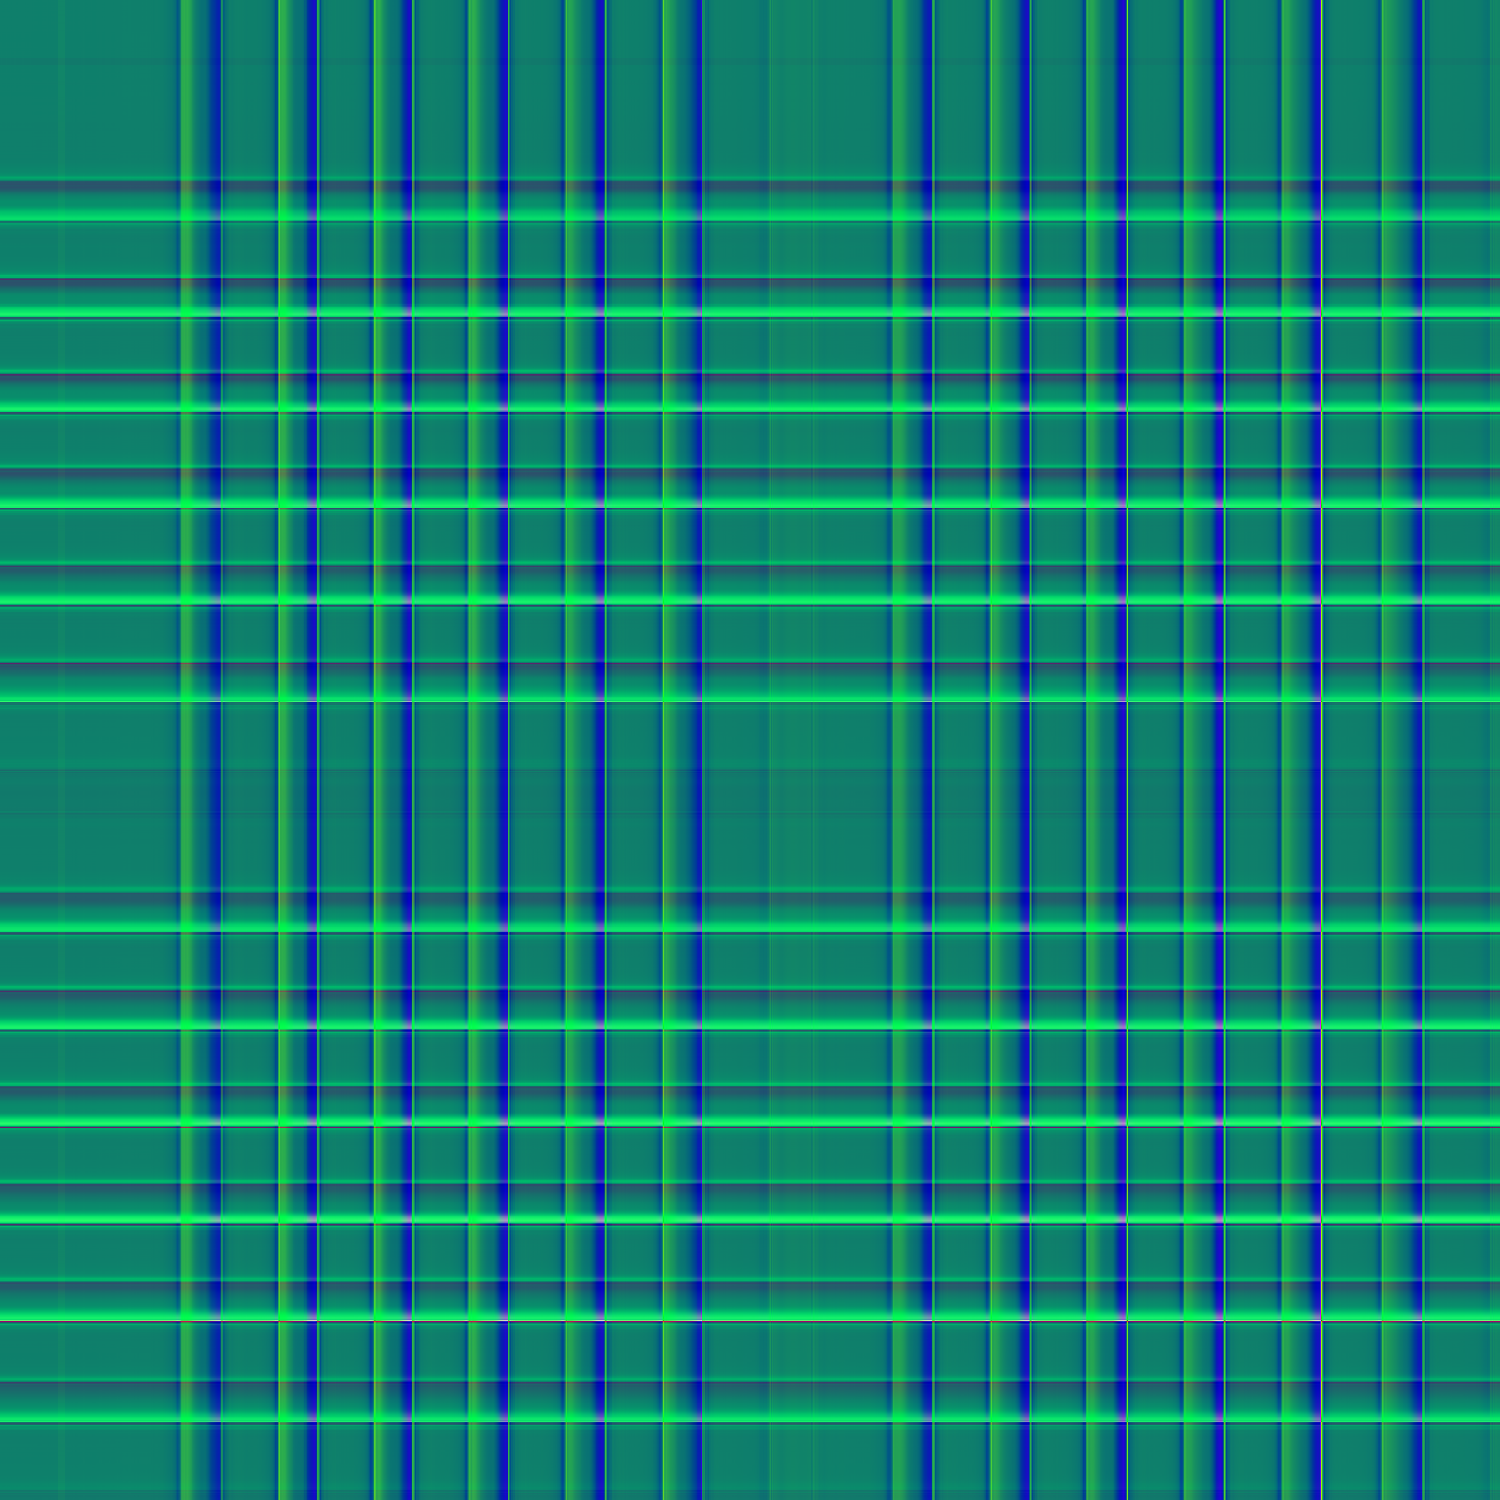

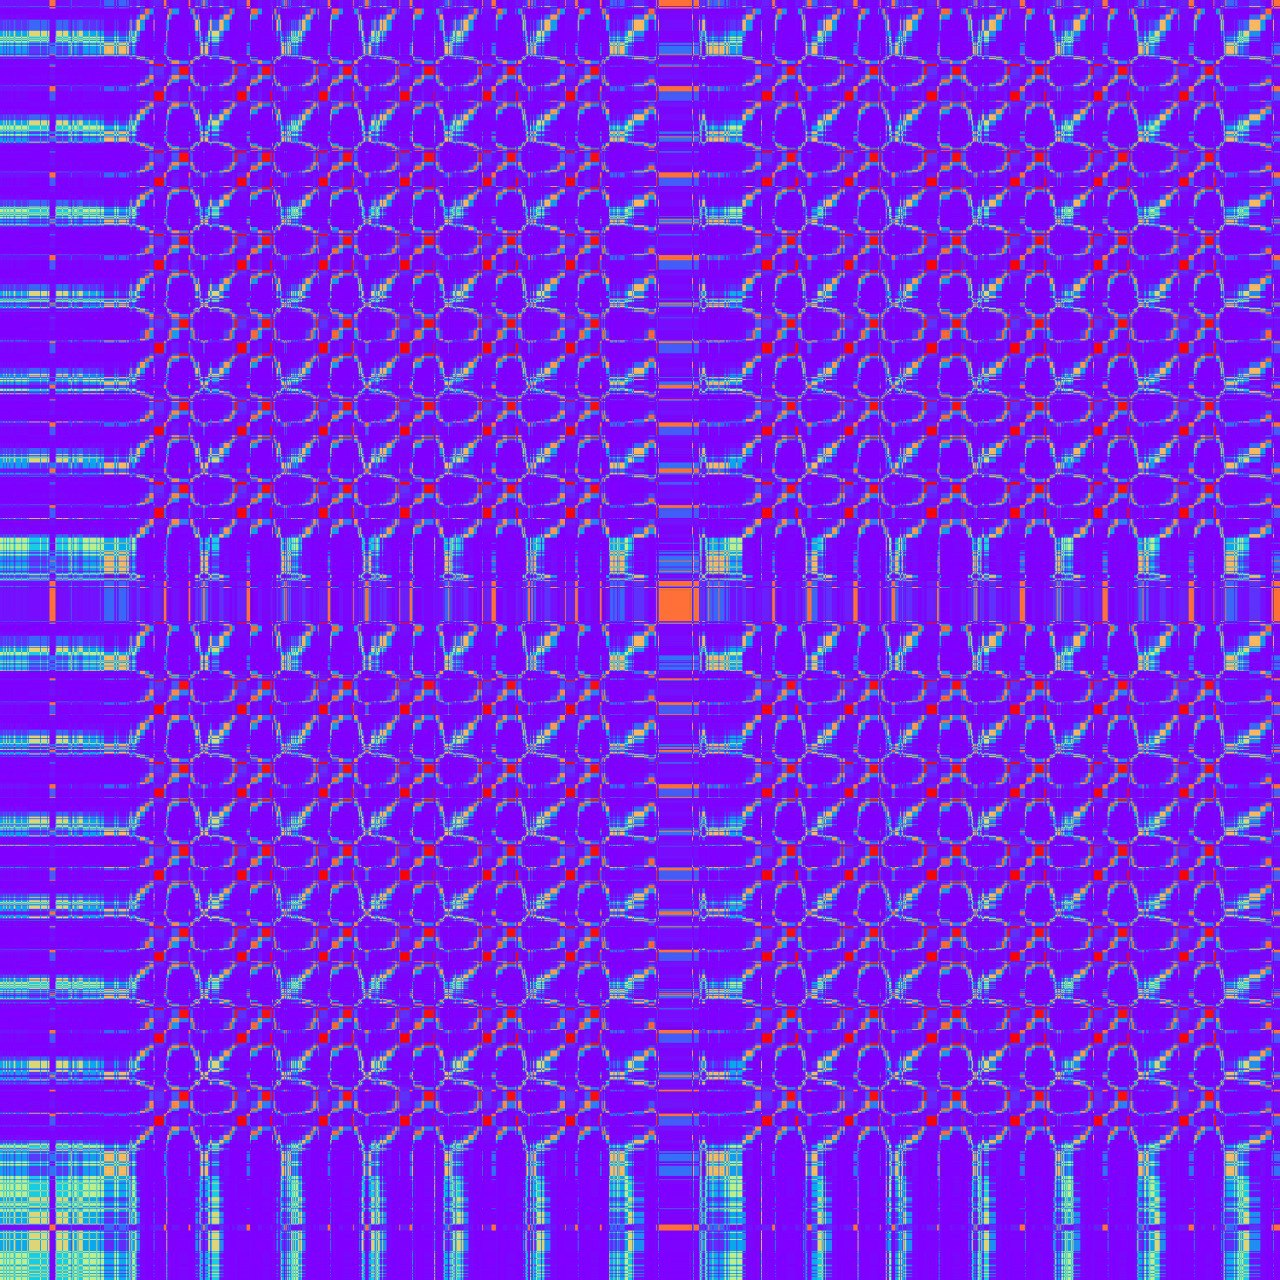

✅ Preprocessed shapes: (1, 224, 224, 3) (1, 224, 224, 3)


✅ Model loaded.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
✅ Predicted Class: S with Confidence: 1.0000


In [15]:
# 📌 Upload Images from Local Machine
from google.colab import files
from IPython.display import display
from PIL import Image
import tensorflow as tf
import numpy as np

print("✅ Please upload the GAF image (RGB)")
uploaded_gaf = files.upload()
gaf_path = list(uploaded_gaf.keys())[0]

print("✅ Please upload the MTF image (RGB)")
uploaded_mtf = files.upload()
mtf_path = list(uploaded_mtf.keys())[0]

# Display the images
display(Image.open(gaf_path))
display(Image.open(mtf_path))

# 🖼️ Preprocessing
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

gaf_test = preprocess_image(gaf_path)
mtf_test = preprocess_image(mtf_path)

print("✅ Preprocessed shapes:", gaf_test.shape, mtf_test.shape)

# ✅ Load the trained model
model = tf.keras.models.load_model('/content/mmcnn_model_final.h5')
print("✅ Model loaded.")

# 🔮 Predict
predictions = model.predict([gaf_test, mtf_test])
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

# Mapping back to class name
class_map = {0: 'EL', 1: 'PD', 2: 'S'}
print(f"✅ Predicted Class: {class_map[predicted_class]} with Confidence: {confidence:.4f}")
